In [195]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
from scipy import optimize
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission
from src.smear import smear
from src.select_tof import select_tof_ptbc, select_tof_fimg
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [3]:
rf = uproot.open("data/RF.root")

In [4]:
rfnp = rf['histfluka;1'].to_numpy()

In [5]:
rfnp

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([1.00000000e-03, 1.02329299e-03, 1.04712855e-03, ...,
        9.54992586e+08, 9.77237221e+08, 1.00000000e+09]),
 array([-200., -199., -198., -197., -196., -195., -194., -193., -192.,
        -191., -190., -189., -188., -187., -186., -185., -184., -183.,
        -182., -181., -180., -179., -178., -177., -176., -175., -174.,
        -173., -172., -171., -170., -169., -168., -167., -166., -165.,
        -164., -163., -162., -161., -160., -159., -158., -157., -156.,
        -155., -154., -153., -152., -151., -150., -149., -148., -147.,
        -146., -145., -144., -143., -142., -141., -140., -139., -138.,
        -137., -136., -135., -134., -133., -132., -131., -130., -129.,
        -128., -127., -126., -125., -124., -123., -122., -121., 

In [6]:
len(rfnp[0][0])

900

In [7]:
len(rfnp[1])

1201

In [8]:
len(rfnp[2])

901

In [28]:
rfnp[1][578]

602.5595860743581

In [21]:
rfnp[1][600]

1000.0

In [35]:
len(rfnp[0][600])

900

In [156]:
tot = np.zeros(900)

In [157]:
for i in range(578, 601):
    tot += rfnp[0][i]

In [158]:
average = tot / 23

In [159]:
mean_dl = np.average((rfnp[2][1:] + rfnp[2][:-1])/ 2, axis = 0, weights = average)/100

In [160]:
sig_dl = np.sqrt(np.cov((rfnp[2][1:] + rfnp[2][:-1])/ 2, aweights= average))/100

In [46]:
print(mean_dl, sig_dl)

0.2197748041962846 0.2972413812367348


In [48]:
f = open("endf/Bi.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[16:27]))
energy = np.array(energy) * 1e6
crs = np.array(crs)

In [49]:
ts = xsec_to_ts(crs * 1e-28, 9747, 0.01, 3.47e-25)

In [164]:
Bi = h5py.File("temp_data/Bi.hdf5", "r")
empty = h5py.File("temp_data/empty.hdf5", "r")

In [218]:
amp_BiIn = Bi['amp'][:]
en_BiIn = Bi['energy'][:]
tof_BiIn = Bi['tof'][:]
norm_BiIn = Bi['norm'][0]
detn_BiIn = Bi['detn'][:]
amp_BiOut = empty['amp'][:]
en_BiOut = empty['energy'][:]
tof_BiOut = empty['tof'][:]
norm_BiOut = empty['norm'][0]
detn_BiOut = empty['detn'][:]

In [217]:
tof_BiIn_select = select_tof_ptbc(tof_BiIn, detn_BiIn, amp_BiIn)
tof_BiOut_select = select_tof_ptbc(tof_BiOut, detn_BiOut, amp_BiOut)

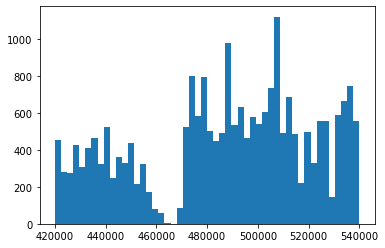

In [167]:
hist_BiIn, bins_BiIn, _ = plt.hist(tof_BiIn_select, bins = 50, range = (420000, 540000))

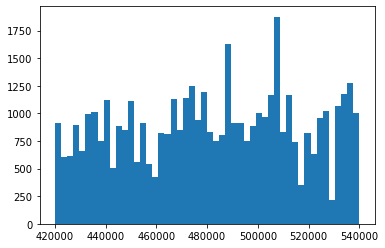

In [168]:
hist_BiOut, bins_BiOut, _ = plt.hist(tof_BiOut_select, bins = 50, range = (420000, 540000))

In [169]:
x_tof = (bins_BiIn[1:] + bins_BiIn[:-1]) / 2
error_BiIn =  np.sqrt(hist_BiIn)
error_BiIn[error_BiIn == 0] = 0.7
tr, tr_error = transmission(hist_BiIn / norm_BiIn, error_BiIn / norm_BiIn, hist_BiOut / norm_BiOut, np.sqrt(hist_BiOut) / norm_BiOut)

In [94]:
def y_fit(energy, L, t):
    energy_smear, crs_smear = smear(energy, crs, mean_dl, sig_dl, 500, 1100, 100, L)
    ts = xsec_to_ts(np.array(crs_smear) * 1e-28, 9747, t, 3.47e-25)[::-1]
    tof = energy_to_tof(energy_smear / 1e6, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    return y_ts

In [95]:
optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182, 0.01], absolute_sigma=True)

(array([1.82298155e+02, 9.98341929e-03]),
 array([[1.77689851e-03, 3.02347170e-07],
        [3.02347170e-07, 5.14048998e-08]]))

In [96]:
np.sqrt(1.77689851e-03)

0.04215327401282135

In [97]:
np.sqrt(5.14048998e-08)

0.0002267264867632364

In [128]:
Al = h5py.File("temp_data/Al5.hdf5", "r")

In [129]:
amp_AlIn = Al['amp'][:]
en_AlIn = Al['energy'][:]
tof_AlIn = Al['tof'][:]
norm_AlIn = Al['norm'][0]
detn_AlIn = Al['detn'][:]
amp_AlOut = empty['amp'][:]
en_AlOut = empty['energy'][:]
tof_AlOut = empty['tof'][:]
norm_AlOut = empty['norm'][0]
detn_AlOut = empty['detn'][:]

In [130]:
f = open("endf/Al.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[16:27]))
energy = np.array(energy) * 1e6
crs = np.array(crs)

In [131]:
rfnp[1][670]

5011.872336272725

In [132]:
rfnp[1][685]

7079.457843841388

In [133]:
tot = np.zeros(900)

In [134]:
for i in range(670, 686):
    tot += rfnp[0][i]

In [135]:
average = tot / 15

In [136]:
mean_dl = np.average((rfnp[2][1:] + rfnp[2][:-1])/ 2, axis = 0, weights = average)/100

In [137]:
sig_dl = np.sqrt(np.cov((rfnp[2][1:] + rfnp[2][:-1])/ 2, aweights= average))/100

In [138]:
print(mean_dl, sig_dl)

0.2914282056211275 0.36507441111770844


In [140]:
tof_AlIn_select = select_tof_ptbc(tof_AlIn, detn_AlIn, amp_AlIn)
tof_AlOut_select = select_tof_ptbc(tof_AlOut, detn_AlOut, amp_AlOut)

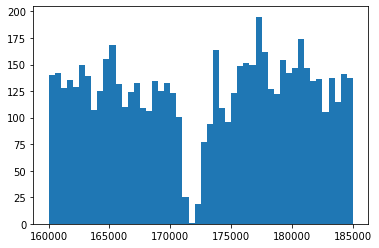

In [141]:
hist_AlIn, bins_AlIn, _ = plt.hist(tof_AlIn_select, bins = 50, range = (160000, 185000))

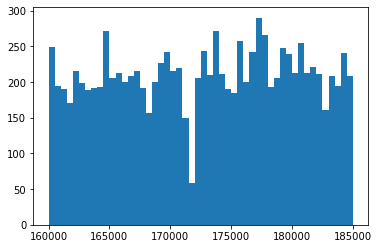

In [142]:
hist_AlOut, bins_AlOut, _ = plt.hist(tof_AlOut_select, bins = 50, range = (160000, 185000))

In [143]:
x_tof = (bins_AlIn[1:] + bins_AlIn[:-1]) / 2
error_AlIn =  np.sqrt(hist_AlIn)
error_AlIn[error_AlIn == 0] = 0.7
tr, tr_error = transmission(hist_AlIn / norm_AlIn, error_AlIn / norm_AlIn, hist_AlOut / norm_AlOut, np.sqrt(hist_AlOut) / norm_AlOut)

In [149]:
def y_fit(energy, L, t):
    energy_smear, crs_smear = smear(energy, crs, mean_dl, sig_dl, 4500, 7500, 100, L)
    ts = xsec_to_ts(np.array(crs_smear) * 1e-28, 2710, t, 4.48e-26)[::-1]
    tof = energy_to_tof(energy_smear / 1e6, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    return y_ts

In [150]:
optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182, 0.08], absolute_sigma=True)

(array([1.82379106e+02, 4.78055097e-02]),
 array([[ 1.71597989e-03, -2.74576885e-06],
        [-2.74576885e-06,  3.39753887e-06]]))

In [152]:
np.sqrt(3.39753887e-06)

0.001843241403072316

In [186]:
f = open("endf/Bi.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[16:27]))
energy = np.array(energy) * 1e6
crs = np.array(crs)

In [161]:
energy_smear, crs_smear = smear(energy, crs, mean_dl, sig_dl, 600, 1000, 100, 182.3)

In [163]:
ts_smear = xsec_to_ts(crs_smear * 1e-28, 9747, 9.98341929e-03, 3.47e-25)

In [171]:
en_BiIn_select = tof_to_energy(tof_BiIn_select / 1e9, 182.3, 939.56542, 299792458) * 1e6
en_BiOut_select = tof_to_energy(tof_BiOut_select / 1e9, 182.3, 939.56542, 299792458) * 1e6

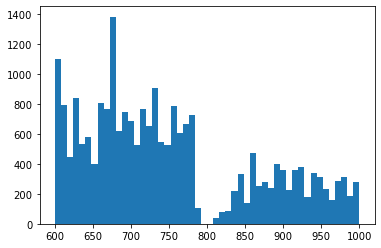

In [173]:
hist_BiIn, bins_BiIn, _ = plt.hist(en_BiIn_select, bins = 50, range = (600, 1000))

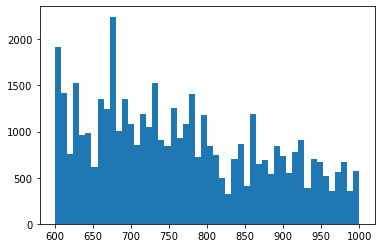

In [174]:
hist_BiOut, bins_BiOut, _ = plt.hist(en_BiOut_select, bins = 50, range = (600, 1000))

In [175]:
x_en = (bins_BiIn[1:] + bins_BiIn[:-1]) / 2
error_BiIn =  np.sqrt(hist_BiIn)
error_BiIn[error_BiIn == 0] = 0.7
tr, tr_error = transmission(hist_BiIn / norm_BiIn, error_BiIn / norm_BiIn, hist_BiOut / norm_BiOut, np.sqrt(hist_BiOut) / norm_BiOut)

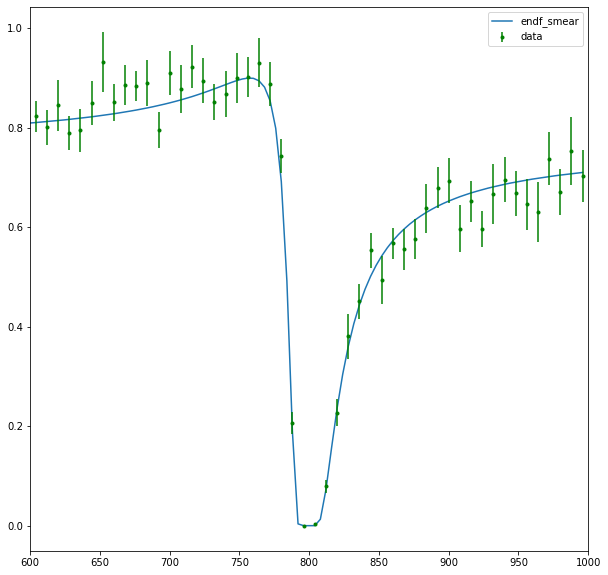

In [176]:
plt.figure(figsize=(10,10))
plt.plot(energy_smear, ts_smear,label='endf_smear')
plt.errorbar(x_en, tr, yerr=tr_error, label = 'data', fmt="g.")
plt.xlim(600,1000)
plt.legend()

In [187]:
tof = energy_to_tof(energy/1e6, 182.3, 939.56542, 299792458) * 1e9
ts = xsec_to_ts(crs * 1e-28, 9747, 9.98341929e-03, 3.47e-25)

In [188]:
tof = tof[::-1]
ts = ts[::-1]

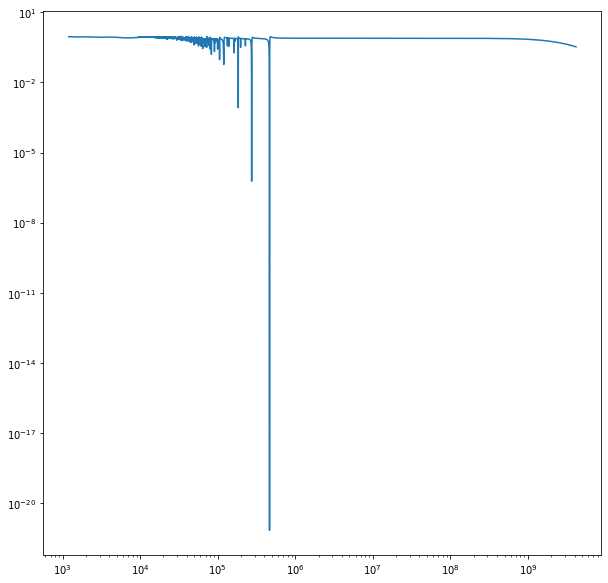

In [191]:
plt.figure(figsize=(10,10))
plt.plot(tof, ts)
plt.xscale('log')
plt.yscale('log')

In [206]:
left = search_asc(tof, 464000)
right = search_asc(tof, 467500)

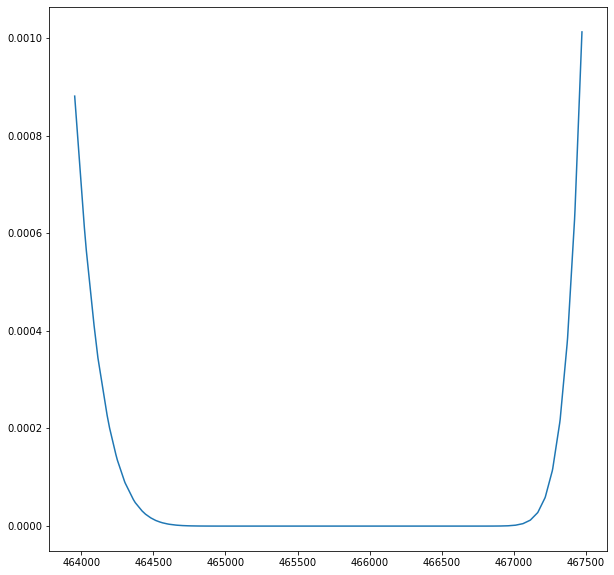

In [207]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [208]:
cur_ts = ts[left]
while(cur_ts > 0.0001):
    left += 1
    cur_ts = ts[left]

In [209]:
left

26572

In [210]:
cur_ts = ts[right]
while(cur_ts > 0.0001):
    right -= 1
    cur_ts = ts[right]

In [211]:
right

26670

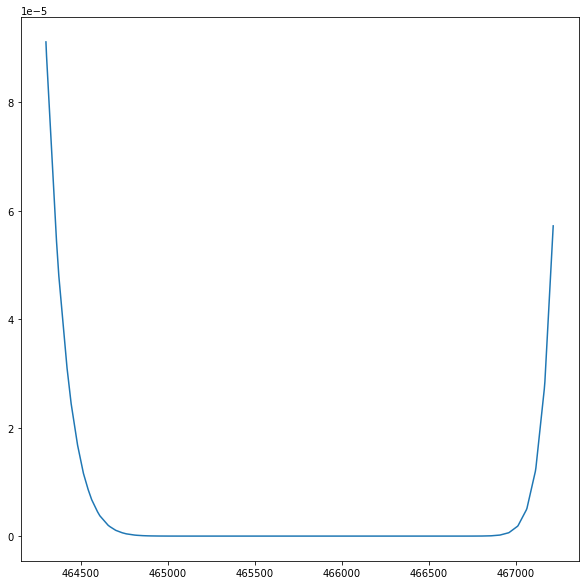

In [212]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [213]:
tof[left]

464300.0203160991

In [214]:
tof[right]

467219.8091169667

In [215]:
tof[right] - tof[left]

2919.7888008675654

In [219]:
tof_BiIn_select = tof_BiIn[(tof_BiIn >= tof[left]) & (tof_BiIn <= tof[right])]
detn_BiIn_select = detn_BiIn[(tof_BiIn >= tof[left]) & (tof_BiIn <= tof[right])]
amp_BiIn_select = amp_BiIn[(tof_BiIn >= tof[left]) & (tof_BiIn <= tof[right])]

In [220]:
tof_BiIn_select_2 = select_tof_ptbc(tof_BiIn_select, detn_BiIn_select, amp_BiIn_select)

In [221]:
tof_BiIn_select_2

array([465086.33996553, 464979.65234603])

In [222]:
norm_BiIn

5.3777341833281536e+17

In [223]:
import math

In [224]:
def poisson(k, mu):
    return mu**k * np.exp(-mu) / math.factorial(k)

In [225]:
0.3173/2

0.15865

In [227]:
def upper_sum(mu):
    return poisson(2, mu) + poisson(1, mu) + poisson(0, mu)

In [235]:
for i in np.linspace(4.5,5,51):
    print(str(i) + " " + str(upper_sum(i)))
#4.64 0.1584325980402317

4.5 0.17357807091003602
4.51 0.1724564054796607
4.52 0.17134096522943798
4.53 0.170231726492846
4.54 0.16912866556581355
4.55 0.168031758708737
4.56 0.1669409821484728
4.57 0.1658563120803034
4.58 0.1647777246698791
4.59 0.16370519605513273
4.6 0.1626387023481714
4.61 0.16157821963714233
4.62 0.16052372398807502
4.63 0.15947519144669783
4.64 0.1584325980402317
4.65 0.1573959197791593
4.66 0.15636513265897078
4.67 0.15534021266188555
4.68 0.15432113575855116
4.69 0.15330787790971875
4.7 0.15230041506789643
4.71 0.1512987231789782
4.72 0.15030277818385213
4.73 0.14931255601998514
4.74 0.14832803262298655
4.75 0.14734918392814833
4.76 0.14637598587196485
4.77 0.14540841439363072
4.78 0.14444644543651677
4.79 0.14349005494962597
4.8 0.1425392188890269
4.81 0.1415939132192677
4.82 0.1406541139147687
4.83 0.13971979696119524
4.84 0.13879093835680936
4.85 0.13786751411380238
4.86 0.13694950025960714
4.87 0.1360368728381908
4.88 0.1351296079113277
4.89 0.13422768155985362
4.9 0.133331069884900

In [241]:
def lower_sum(mu):
    return 1 - poisson(0, mu) - poisson(1, mu)

In [246]:
for i in np.linspace(0.7,0.8,101):
    print(str(i) + " " + str(lower_sum(i)))
#0.709 0.1589394263557114

0.7 0.15580498355460382
0.701 0.1561526676475074
0.702 0.15650050007110722
0.703 0.15684848018155323
0.704 0.15719660733613489
0.705 0.1575448808932784
0.706 0.15789330021254588
0.707 0.15824186465463314
0.708 0.15859057358136858
0.709 0.1589394263557114
0.71 0.15928842234174967
0.711 0.15963756090469894
0.712 0.15998684141090092
0.713 0.16033626322782119
0.714 0.16068582572404816
0.715 0.16103552826929135
0.716 0.16138537023437954
0.717 0.16173535099125957
0.718 0.16208546991299377
0.719 0.1624357263737602
0.72 0.16278611974884866
0.721 0.1631366494146615
0.722 0.16348731474870998
0.723 0.16383811512961421
0.724 0.16418904993710032
0.725 0.16454011855199974
0.726 0.16489132035624748
0.727 0.16524265473288036
0.728 0.165594121066035
0.729 0.16594571874094727
0.73 0.16629744714394973
0.731 0.16664930566247071
0.732 0.16700129368503247
0.733 0.1673534106012492
0.734 0.16770565580182656
0.735 0.16805802867855868
0.736 0.16841052862432804
0.737 0.16876315503310285
0.738 0.16911590729993575

In [247]:
2 / 2919.7888008675654 / norm_BiIn

1.2737354192853852e-21

In [249]:
4.64 / 2919.7888008675654 / norm_BiIn

2.9550661727420935e-21

In [250]:
0.709 / 2919.7888008675654 / norm_BiIn

4.515392061366691e-22